In [1]:
# for colab to work with drive... change this as needed or comment out
!ln -s "drive/My Drive/Colab Notebooks/UVM Principles of Complex Systems/project"/*/ .

In [2]:
%env DATADIR=data
%env OUTDIR=out

env: DATADIR=data
env: OUTDIR=out


In [3]:
!bzip2 -kcd "$DATADIR/Calls.csv.bz2" > tmp/Calls.csv
!bzip2 -kcd "$DATADIR/Proximity.csv.bz2" > tmp/Proximity.csv
!bzip2 -kcd "$DATADIR/SMS.csv.bz2" > tmp/SMS.csv
!bzip2 -kcd "$DATADIR/WLAN2.csv.bz2" > tmp/WLAN2.csv

In [4]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [5]:
datadir = os.getenv("DATADIR")
outdir = os.getenv("OUTDIR")
datadir, outdir

('data', 'out')

# Data

In [6]:
calls = pd.read_csv("tmp/Calls.csv")
calls

,user_id,time_stamp,duration,dest_user_id_if_known,dest_phone_hash
0,19.0,2008-10-02 22:04:28,15,NaN,2088297235
1,19.0,2008-10-02 22:03:57,17,NaN,2088297235
2,19.0,2008-10-03 00:42:55,421,NaN,2939471263
3,19.0,2008-10-03 00:42:06,0,NaN,2088297235
4,19.0,2008-10-03 03:47:31,47,18.0,3620995333
...,...,...,...,...,...
63819,1.0,2008-11-02 21:12:49,0,NaN,1735071629
63820,1.0,2008-11-04 20:50:42,44,NaN,2867604986
63821,1.0,2008-11-04 21:08:52,173,61.0,3480933661
63822,1.0,2008-11-06 03:37:19,26,61.0,3480933661


In [7]:
proximity = pd.read_csv("tmp/Proximity.csv")
proximity

,user.id,remote.user.id.if.known,time,prob2
0,58,42,2007-09-05 14:02:11,0.034
1,58,49,2007-09-05 14:02:11,0.000
2,58,54,2007-09-05 14:02:11,NaN
3,58,57,2007-09-05 14:02:11,0.233
4,58,74,2007-09-05 14:02:11,NaN
...,...,...,...,...
2124559,64,43,2009-07-16 15:56:25,NaN
2124560,64,43,2009-07-16 16:01:57,NaN
2124561,64,62,2009-07-16 18:30:11,0.000
2124562,64,62,2009-07-16 18:35:26,0.000


In [8]:
sms = pd.read_csv("tmp/SMS.csv", encoding="iso-8859-1")
sms

,user.id,time,incoming,dest.user.id.if.known,dest.phone.hash
0,61,2008-01-01 15:00:25,0,1.0,3502965008
1,61,2008-01-01 15:00:25,0,61.0,3480933661
2,61,2008-01-01 15:00:25,1,1.0,3502965008
3,61,2008-01-01 15:00:25,1,NaN,177622
4,61,2008-01-01 15:00:25,1,61.0,3480933661
...,...,...,...,...,...
76532,7,2009-06-26 21:16:06,0,4.0,3708966819
76533,7,2009-06-26 21:17:34,1,4.0,3708966819
76534,7,2009-06-27 22:45:38,1,4.0,3708966819
76535,7,2009-06-27 23:26:58,0,4.0,3708966819


In [9]:
wlan = pd.read_csv("tmp/WLAN2.csv")
wlan

,user_id,time,wireless_mac,strength,unix_time
0,14,2008-10-01 18:45:30,1278,-89,1222901130
1,14,2008-10-01 18:45:30,5476,-96,1222901130
2,14,2008-10-01 18:45:30,8549,-92,1222901130
3,14,2008-10-01 18:45:30,16319,-95,1222901130
4,14,2008-10-01 18:45:30,17373,-96,1222901130
...,...,...,...,...,...
1998041,22,2009-05-31 20:57:58,703,-60,1243817878
1998042,22,2009-05-31 20:57:58,707,-69,1243817878
1998043,22,2009-05-31 20:57:58,822,-75,1243817878
1998044,22,2009-05-31 20:57:58,5830,-53,1243817878


In [10]:
wlan["time"] = pd.to_datetime(wlan['time'])
proximity["time"] = pd.to_datetime(proximity['time'])

## Time resolution

Align the WLAN and proximity data within a specified interval

In [11]:
time_res = "20s"

In [12]:
wlan["r_time"] = wlan["time"].round(time_res)
proximity["r_time"] = proximity["time"].round(time_res)
wlan, proximity

(         user_id                time  ...   unix_time              r_time
 0             14 2008-10-01 18:45:30  ...  1222901130 2008-10-01 18:45:20
 1             14 2008-10-01 18:45:30  ...  1222901130 2008-10-01 18:45:20
 2             14 2008-10-01 18:45:30  ...  1222901130 2008-10-01 18:45:20
 3             14 2008-10-01 18:45:30  ...  1222901130 2008-10-01 18:45:20
 4             14 2008-10-01 18:45:30  ...  1222901130 2008-10-01 18:45:20
 ...          ...                 ...  ...         ...                 ...
 1998041       22 2009-05-31 20:57:58  ...  1243817878 2009-05-31 20:58:00
 1998042       22 2009-05-31 20:57:58  ...  1243817878 2009-05-31 20:58:00
 1998043       22 2009-05-31 20:57:58  ...  1243817878 2009-05-31 20:58:00
 1998044       22 2009-05-31 20:57:58  ...  1243817878 2009-05-31 20:58:00
 1998045       22 2009-05-31 20:57:58  ...  1243817878 2009-05-31 20:58:00
 
 [1998046 rows x 6 columns],
          user.id  remote.user.id.if.known  ...  prob2              r

## Exploration

In [13]:
# interaction counts for a given time interval (adjust freq)
# most data through Oct-Nov
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(proximity.groupby(pd.Grouper(key='r_time', freq='M', label='right')).size())

r_time
2007-09-30        23
2007-10-31         0
2007-11-30         0
2007-12-31         0
2008-01-31       868
2008-02-29       797
2008-03-31         0
2008-04-30       547
2008-05-31         0
2008-06-30         0
2008-07-31       114
2008-08-31      1467
2008-09-30       347
2008-10-31    176090
2008-11-30    123990
2008-12-31     79842
2009-01-31    115875
2009-02-28    315698
2009-03-31    427333
2009-04-30    451679
2009-05-31    409012
2009-06-30     19676
2009-07-31      1206
Freq: M, dtype: int64


In [14]:
# individual interaction counts for a given time interval (adjust freq)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    for k, g in proximity.groupby(pd.Grouper(key='r_time', freq='M', label='right')):
        print(k)
        print(g.groupby(['user.id', 'remote.user.id.if.known']).size())

Streaming output truncated to the last 5000 lines.
         62                           34
         63                           39
         64                            9
         67                            2
         68                            2
         69                            6
         70                           44
         71                          514
         72                            6
         75                            2
         76                          815
         77                           53
         79                           10
         80                            3
4        1                           168
         2                             9
         5                             4
         6                             2
         7                          1701
         8                            19
         9                           393
         11                         2495
         14                           28
      

In [15]:
def get_interact_counts(data, id=None, freq='W', start=None, end=None):
    # data is a dataframe with the variables seen below
    # id is the user id
    # freq is the time offset (minutely, daily, weekly, etc.) https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
    # start, end is the start and end of the interval
    df = data

    out = {}
    if start:
        df = df[df['r_time'] > start]
    if end:
        df = df[df['r_time'] < end]
    for k, g in df.groupby(pd.Grouper(key='r_time', freq=freq, label='right')):
        if id:
            g = g[g['user.id'] == id]
        g_size = g.groupby(['user.id', 'remote.user.id.if.known']).size()
        out[k] = g_size
    return out

get_interact_counts(proximity, id=55, freq='D', start='2009-03-08', end='2009-04-05')

{Timestamp('2009-03-09 00:00:00', freq='D'): user.id  remote.user.id.if.known
 55       2                            2
          5                           18
          14                          17
          16                           2
          20                          31
          21                          11
          22                           1
          23                         101
          33                           4
          34                          62
          36                           1
          42                          83
          43                          20
          44                          63
          46                          13
          57                           3
          59                          45
          63                          20
          64                          11
          71                          28
          76                          36
          77                          84
          79        

**TODO**: Study the scaling and dynamics of the interaction counts.


## Merge

Merge the WLAN and proximity data on user ID and the rounded time.

In [16]:
# removes any where remote user id is NA
wlan_prox = pd.merge(wlan, proximity, how='right', left_on=['user_id', 'r_time'], right_on=['user.id', 'r_time'], suffixes=["_wlan", "_prox"]).dropna(subset=["remote.user.id.if.known"])
wlan_prox['remote.user.id.if.known'] = np.int64(wlan_prox['remote.user.id.if.known'])
wlan_prox['user.id'] = np.int64(wlan_prox['user.id'])
wlan_prox

,user_id,time_wlan,wireless_mac,strength,unix_time,r_time,user.id,remote.user.id.if.known,time_prox,prob2
0,NaN,NaT,NaN,NaN,NaN,2007-09-05 14:02:20,58,42,2007-09-05 14:02:11,0.034
1,NaN,NaT,NaN,NaN,NaN,2007-09-05 14:02:20,58,49,2007-09-05 14:02:11,0.000
2,NaN,NaT,NaN,NaN,NaN,2007-09-05 14:02:20,58,54,2007-09-05 14:02:11,NaN
3,NaN,NaT,NaN,NaN,NaN,2007-09-05 14:02:20,58,57,2007-09-05 14:02:11,0.233
4,NaN,NaT,NaN,NaN,NaN,2007-09-05 14:02:20,58,74,2007-09-05 14:02:11,NaN
...,...,...,...,...,...,...,...,...,...,...
2233455,NaN,NaT,NaN,NaN,NaN,2009-07-16 15:56:20,64,43,2009-07-16 15:56:25,NaN
2233456,NaN,NaT,NaN,NaN,NaN,2009-07-16 16:02:00,64,43,2009-07-16 16:01:57,NaN
2233457,NaN,NaT,NaN,NaN,NaN,2009-07-16 18:30:20,64,62,2009-07-16 18:30:11,0.000
2233458,NaN,NaT,NaN,NaN,NaN,2009-07-16 18:35:20,64,62,2009-07-16 18:35:26,0.000


In [17]:
df_interact_size = wlan_prox[['user_id', 'remote.user.id.if.known']].groupby(['user_id', 'remote.user.id.if.known']).size().to_frame("size").reset_index()
df_interact_size['user_id'] = df_interact_size['user_id'].astype(int)
df_interact_size

,user_id,remote.user.id.if.known,size
0,1,2,162
1,1,4,26
2,1,11,100
3,1,14,494
4,1,20,14
...,...,...,...
1075,79,64,6
1076,79,66,6
1077,79,68,168
1078,79,71,11


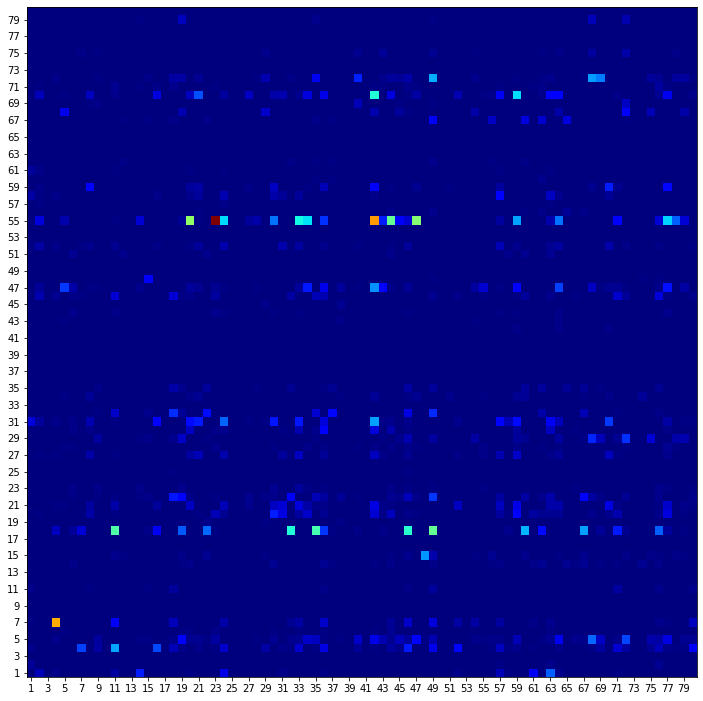

In [18]:
max_id = max(df_interact_size['user_id'].max(), df_interact_size['remote.user.id.if.known'].max())
freq_mat = np.zeros((max_id, max_id))
for index, row in df_interact_size.iterrows():
    user_id, remote_id, size = row
    freq_mat[user_id-1, remote_id-1] += size

fig, ax = plt.subplots(figsize=(12, 16))
ax.imshow(freq_mat, cmap='jet')
ax.invert_yaxis()
ax.set_xticks(np.arange(0, max_id, 2), minor=False)
ax.set_yticks(np.arange(0, max_id, 2), minor=False)
ax.set_xticklabels(np.arange(1, max_id, 2), minor=False)
ax.set_yticklabels(np.arange(1, max_id, 2), minor=False)
#ax.set_xticklabels([])
#ax.set_yticklabels([])
fig.savefig(os.path.join(outdir, 'interact_freq.png'), bbox_inches='tight')

# Graph

## Prototype

In [19]:
wlan_prox

,user_id,time_wlan,wireless_mac,strength,unix_time,r_time,user.id,remote.user.id.if.known,time_prox,prob2
0,NaN,NaT,NaN,NaN,NaN,2007-09-05 14:02:20,58,42,2007-09-05 14:02:11,0.034
1,NaN,NaT,NaN,NaN,NaN,2007-09-05 14:02:20,58,49,2007-09-05 14:02:11,0.000
2,NaN,NaT,NaN,NaN,NaN,2007-09-05 14:02:20,58,54,2007-09-05 14:02:11,NaN
3,NaN,NaT,NaN,NaN,NaN,2007-09-05 14:02:20,58,57,2007-09-05 14:02:11,0.233
4,NaN,NaT,NaN,NaN,NaN,2007-09-05 14:02:20,58,74,2007-09-05 14:02:11,NaN
...,...,...,...,...,...,...,...,...,...,...
2233455,NaN,NaT,NaN,NaN,NaN,2009-07-16 15:56:20,64,43,2009-07-16 15:56:25,NaN
2233456,NaN,NaT,NaN,NaN,NaN,2009-07-16 16:02:00,64,43,2009-07-16 16:01:57,NaN
2233457,NaN,NaT,NaN,NaN,NaN,2009-07-16 18:30:20,64,62,2009-07-16 18:30:11,0.000
2233458,NaN,NaT,NaN,NaN,NaN,2009-07-16 18:35:20,64,62,2009-07-16 18:35:26,0.000


In [20]:
interact_graph = nx.from_pandas_edgelist(df_interact_size, source="user_id", target="remote.user.id.if.known", edge_attr="size")

In [21]:
centrality = nx.degree_centrality(interact_graph)
for k, c in centrality.items():
    interact_graph.nodes[k].update({'centrality': c})

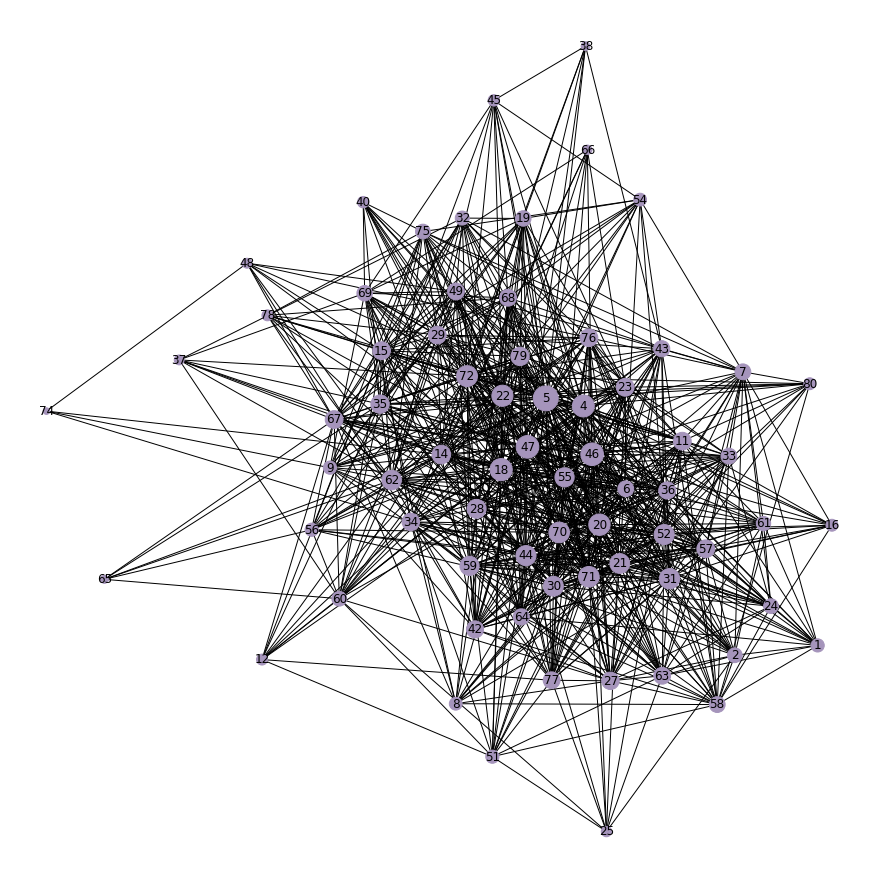

In [22]:
plt.figure(figsize=(12, 12))
nx.draw_spring(interact_graph, node_size=750 * np.array(list(centrality.values())), node_color="#A594BB", with_labels=True)

In [23]:
np.sum((wlan_prox['user_id'] == 39) | (wlan_prox['remote.user.id.if.known'] == 39))

0

## Individual Interaction Graphs - "Oh yeah. It's all coming together."

In [24]:
def construct_graphs(*args, **kwargs):
    outs = {}
    counts = get_interact_counts(*args, **kwargs)
    for t, df in counts.items():
        df = df.to_frame("size").reset_index()
        interact_graph = nx.from_pandas_edgelist(df, source='user.id', target='remote.user.id.if.known', edge_attr='size')
        outs[t] = interact_graph
    return outs

In [25]:
for t, ig in construct_graphs(wlan_prox, id=55, freq='D', start='2009-03-08', end='2009-04-05').items():
    plt.figure(figsize=(12,12))
    plt.title(t)
    nx.draw_spring(ig, node_size=[50*c for c in nx.degree_centrality(ig)], node_color="#A594BB", with_labels=True)

Output hidden; open in https://colab.research.google.com to view.

## Interaction Graphs

In [26]:
for t, ig in construct_graphs(wlan_prox, freq='D', start='2009-03-08', end='2009-04-05').items():
    plt.figure(figsize=(12,12))
    plt.title(t)
    nx.draw_spring(ig, node_size=[10*c for c in nx.degree_centrality(ig)], node_color="#A594BB", with_labels=True)

Output hidden; open in https://colab.research.google.com to view.